In [18]:
%matplotlib inline

from datetime import datetime
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import statsmodels.api as sm

# # NBER recessions
# from pandas_datareader.data import DataReader

# usrec = DataReader(

#     "USREC", "fred", start=datetime(1947, 1, 1), end=datetime(2024, 3, 7)
# )
# usrec.head()

# Markov Switching Autoregression Model

In [19]:
raw = pd.read_csv('../data/s&p1978_2024.csv', skipfooter=1)
raw.drop([' Open', ' High', ' Low', 'Return'],axis=1,inplace=True)
raw.rename(columns={'Return': 'Return', ' Date':'Date',' Close':'Close'},inplace=True)

# Convert the 'date' column to datetime
raw['Date'] = pd.to_datetime(raw['Date'])

# Set 'Date' as the index
raw.set_index('Date', inplace=True)
raw_close_price_analysis=raw
# Resample the data into weekly timeframe
raw = raw.resample('W').first()

# # Reverse the DataFrame
# raw = raw.iloc[::-1]

# Calculate the percentage change from month to month
raw = raw.pct_change()

raw_uncompressed_returns = raw
# Apply log transformation to the returns to compress the data
raw = np.log1p(raw)

# # Center the data around 0
# raw = raw - raw.mean()

# Drop NA values
raw.dropna(inplace=True)

raw


/var/folders/7r/gmcfwl7x7f35wnm9l7114rtw0000gn/T/ipykernel_32953/3657724969.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  raw = pd.read_csv('../data/s&p1978_2024.csv', skipfooter=1)
/var/folders/7r/gmcfwl7x7f35wnm9l7114rtw0000gn/T/ipykernel_32953/3657724969.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw['Date'] = pd.to_datetime(raw['Date'])


,Close
Date,
1978-01-15,-0.031280
1978-01-22,-0.013439
1978-01-29,-0.002127
1978-02-05,0.001120
1978-02-12,0.001789
...,...
2024-02-11,0.003015
2024-02-18,0.015862
2024-02-25,-0.009269


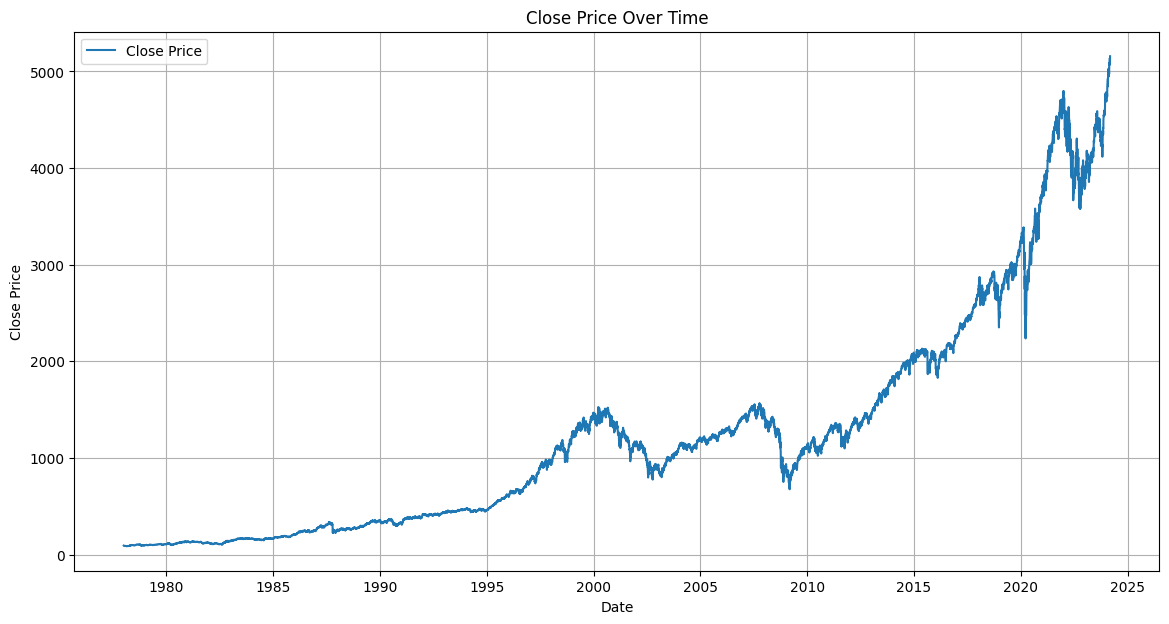

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(raw_close_price_analysis.index, raw_close_price_analysis['Close'], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

## Test for stationarity

In [21]:
from statsmodels.tsa.stattools import adfuller,kpss

result = adfuller(raw)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
    print("ADF test: The data are non-stationary")
else:
    print("ADF test: The data are stationary")

# Perform KPSS test
result = kpss(raw)
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
    print("KPSS test: The data are stationary")
else:
    print("KPSS test: The data are non-stationary")

ADF Statistic: -53.937036577775864
p-value: 0.0
ADF test: The data are non-stationary
KPSS Statistic: 0.07887408752334292
p-value: 0.1
KPSS test: The data are non-stationary


/var/folders/7r/gmcfwl7x7f35wnm9l7114rtw0000gn/T/ipykernel_32953/564294296.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(raw)


<Axes: title={'center': 'Excess returns'}, xlabel='Date'>

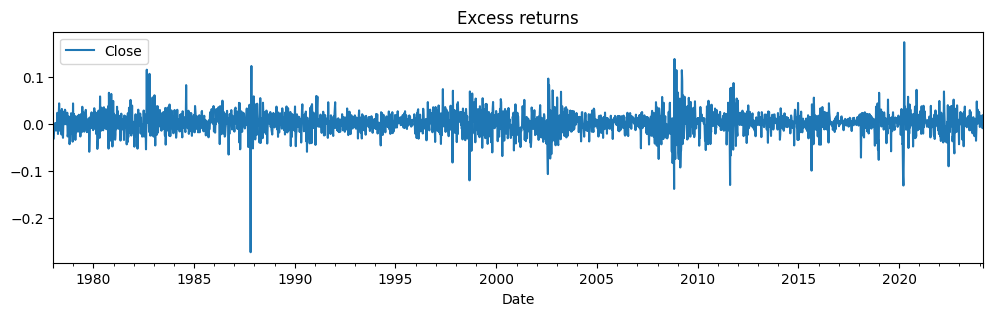

In [22]:
raw_uncompressed_returns.plot(title="Excess returns", figsize=(12, 3))

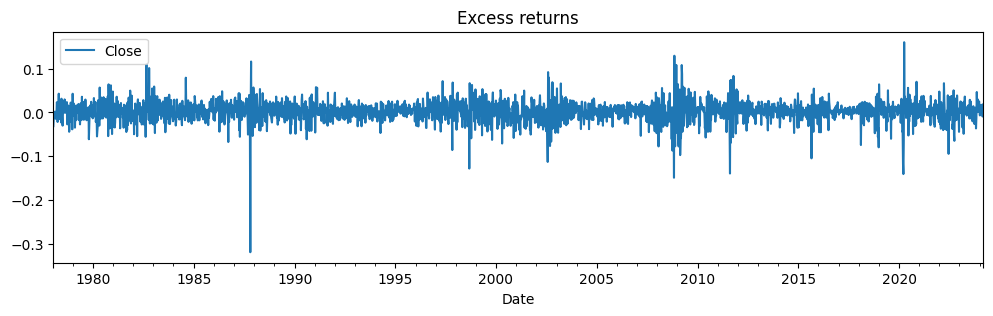

In [23]:
# Get the dataset



# dta_kns = raw.loc[:'2024'] - raw.loc[:'2024'].mean()
dta_kns = raw

# Plot the dataset
dta_kns.plot(title="Excess returns", figsize=(12, 3))
# Fit the model
mod_kns = sm.tsa.MarkovRegression(
    dta_kns, k_regimes=2, trend="n", switching_variance=True
)
res_kns = mod_kns.fit()


In [24]:
res_kns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2409
Model:               MarkovRegression   Log Likelihood                5767.648
Date:                Sun, 31 Mar 2024   AIC                         -11527.296
Time:                        18:11:52   BIC                         -11504.148
Sample:                    01-15-1978   HQIC                        -11518.876
                         - 03-10-2024                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   1.75e-05     18.266      0.000       0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0022      0.000      8.492      0.000       0.002       0.003
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9807      0.005    196.525      0.000       0.971       0.990
p[1->0]        0.0979      0.024      4.046      0.000       0.050       0.145
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

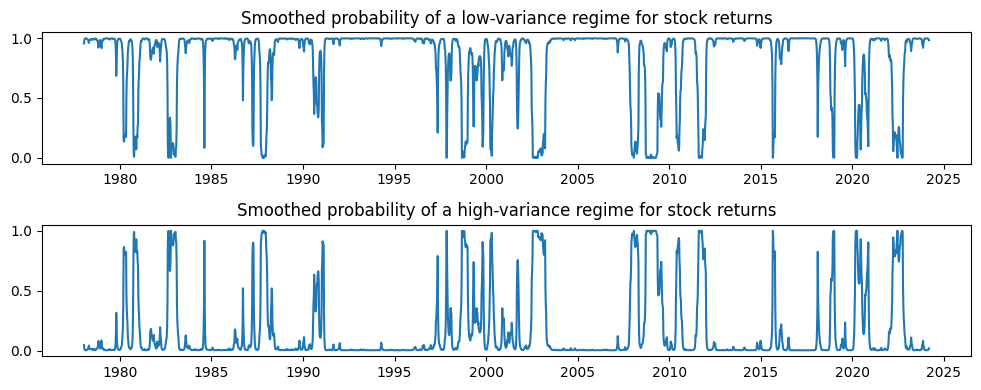

In [25]:
fig, axes = plt.subplots(2, figsize=(10, 4))

ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title="Smoothed probability of a low-variance regime for stock returns")

ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of a high-variance regime for stock returns")

fig.tight_layout()


## On average, low variance lasts 96 days and high variance lasts 27 days

In [26]:
print(res_kns.expected_durations)

[51.81846371 10.21054757]


## Get daily S&P data

In [27]:
sp = pd.read_csv('../data/s&p1978_2024.csv', skipfooter=1,engine='python')
# sp.drop([' Open', ' High', ' Low', ' Close'],axis=1,inplace=True)
sp.rename(columns={' Return': 'Return', ' Date':'Date',' Open':'Open',' High':'High',' Low':'Low',' Close':'Close'},inplace=True)
sp=sp.iloc[::-1]
# Convert the 'date' column to datetime
sp['Date'] = pd.to_datetime(sp['Date'])

# Format the 'date' column in the desired format
sp['Date'] = sp['Date'].dt.strftime('%Y-%m-%d')
sp.set_index('Date',inplace=True)
sp1= sp.drop(columns=['Open','High','Low','Return'])


/var/folders/7r/gmcfwl7x7f35wnm9l7114rtw0000gn/T/ipykernel_32953/1191981867.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sp['Date'] = pd.to_datetime(sp['Date'])


## Calculate Triangular Moving Average

In [28]:
def calculate_TMA(data, period):
    """Calculates a Triangular Moving Average (TMA).

    Args:
        data: A pandas Series of price data
        period: The period of the moving average.

    Returns:
        A pandas Series containing the TMA calculation
    """

    SMA = data.rolling(period).mean()  # Calculate a simple moving average first
    TMA = SMA.rolling(period).mean()   # Smooth the SMA to get the TMA
    return TMA

period = 200
TMA = calculate_TMA(sp1, period)
sp1['TMA']=TMA['Close']

In [29]:
sp1.tail()

,Close,TMA
Date,,
2024-03-01,5137.08,4209.225794
2024-03-04,5130.95,4212.015419
2024-03-05,5078.65,4214.827038
2024-03-06,5104.76,4217.658653
2024-03-07,5157.36,4220.513482


## Calculate ATR

In [30]:
from ta.volatility import AverageTrueRange

atr = AverageTrueRange(high=sp['High'], low=sp['Low'], close=sp['Close'], window=20)
sp1['ATR']=atr.average_true_range()

## Add state probabilities to the dataframe

In [31]:
# sp1[['low_var','high_var']]=res_kns.smoothed_marginal_probabilities

res_kns_smoothed_marginal_probabilities = pd.DataFrame(res_kns.smoothed_marginal_probabilities)
sp1.index = pd.to_datetime(sp1.index)

res_kns_smoothed_marginal_probabilities.index = pd.to_datetime(res_kns_smoothed_marginal_probabilities.index)
# Resample the monthly data to daily data
marginal_probs_daily = res_kns_smoothed_marginal_probabilities.resample('D').ffill()

# Merge the two dataframes on the date
sp1 = sp1.merge(marginal_probs_daily, left_index=True, right_index=True, how='inner')

sp1.tail()

,Close,TMA,ATR,0,1
Date,,,,,
2024-03-01,5137.08,4209.225794,42.351336,0.994032,0.005968
2024-03-04,5130.95,4212.015419,41.358269,0.989347,0.010653
2024-03-05,5078.65,4214.827038,42.996855,0.989347,0.010653
2024-03-06,5104.76,4217.658653,43.313013,0.989347,0.010653
2024-03-07,5157.36,4220.513482,44.190362,0.989347,0.010653


In [32]:
sp1.rename(columns={0:'low_var',1:'high_var'},inplace=True)
sp1.head()

,Close,TMA,ATR,low_var,high_var
Date,,,,,
1978-01-16,89.43,NaN,0.0,0.954984,0.045016
1978-01-17,89.88,NaN,0.0,0.954984,0.045016
1978-01-18,90.56,NaN,0.0,0.954984,0.045016
1978-01-19,90.09,NaN,0.0,0.954984,0.045016
1978-01-20,89.89,NaN,0.0,0.954984,0.045016


## Plotting TMA with closing price

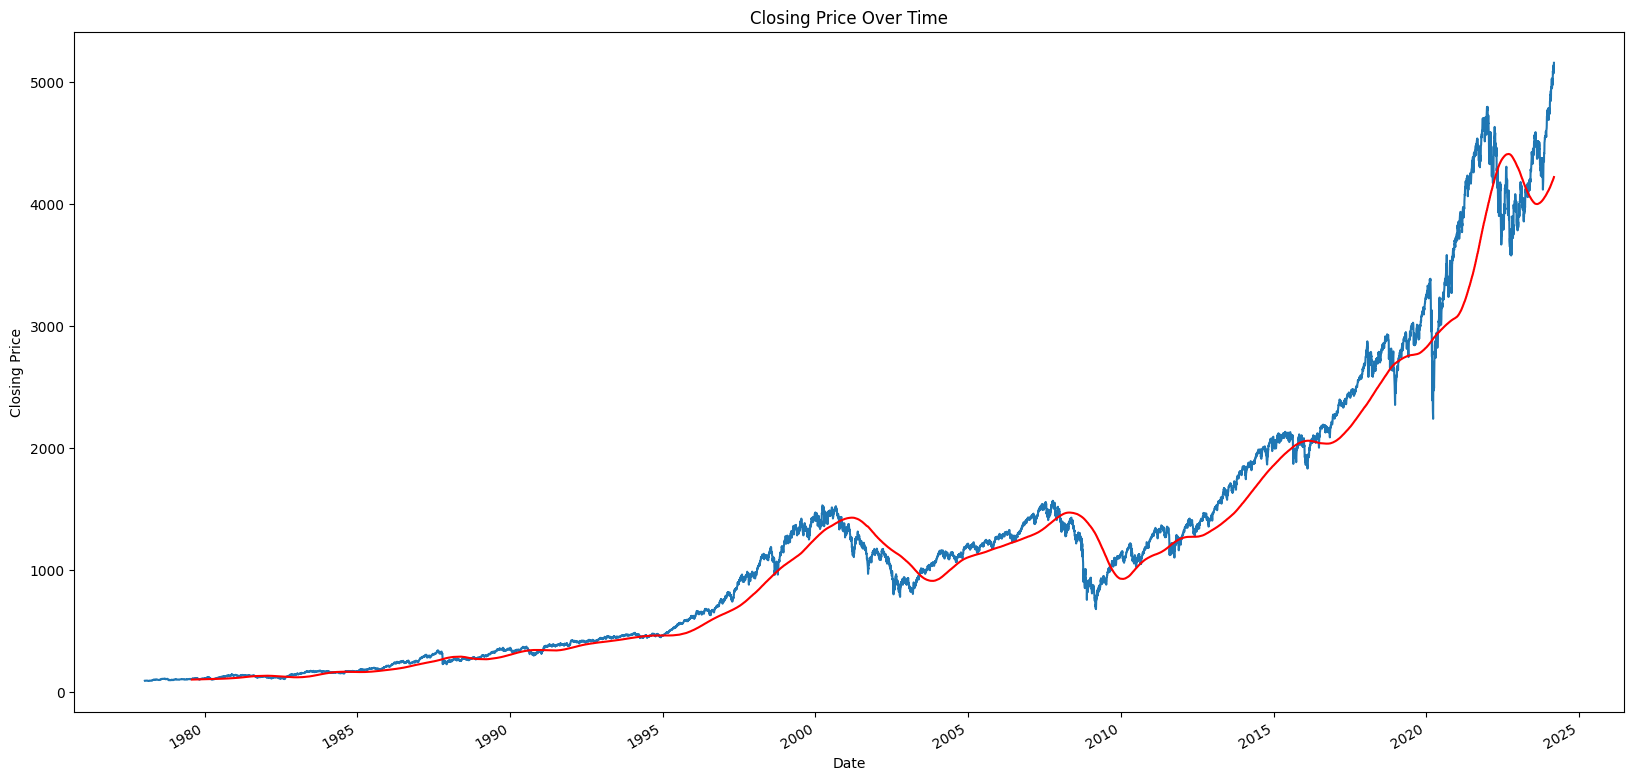

In [33]:
# Assuming 'sp' is your DataFrame and 'Close' is the column with closing prices
sp1['Close'].plot(figsize=(20,10))
sp1['TMA'].plot(color='red', label='TMA')

plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')

plt.show()

In [34]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming 'sp1' is your DataFrame, 'Close' is the column with closing prices,
# # and 'TMA' is the column with the moving average

# plt.figure(figsize=(50,25))

# # Plot the closing price and moving average
# plt.plot(sp1.index, sp1['Close'], label='Close', color='black')
# plt.plot(sp1.index, sp1['TMA'], label='Moving Average', color='blue')

# # Color the background green where the closing price is above the moving average
# plt.fill_between(sp1.index, sp1['Close'].min(), sp1['Close'].max(), where=(sp1['Close'] > sp1['TMA']), color='green', alpha=0.5, interpolate=True)

# # Color the background red where the closing price is below the moving average
# plt.fill_between(sp1.index, sp1['Close'].min(), sp1['Close'].max(), where=(sp1['Close'] <= sp1['TMA']), color='red', alpha=0.5, interpolate=True)

# plt.title('Closing Price and Moving Average Over Time')
# plt.xlabel('Date')
# plt.ylabel('Price')

# # Add a legend
# plt.legend()

# plt.show()

## Categorise

In [57]:
def categorize_regime_only(row):
    if row['high_var'] > row['low_var']:
        return 'red'
    else:
        return 'blue'
    
def categorize(row, prev_row):
    if abs(row['Close'] - row['TMA']) < row['ATR']:
        return prev_row['color']
    elif row['Close'] > row['TMA']:
        return 'blue' if row['low_var'] > row['high_var'] else 'green'
    else:
        return 'pink' if row['low_var'] > row['high_var'] else 'red'

sp1['color'] = None
prev_row = {'color': 'green'}  # Initialize with the color of the first row
colors = []
for i, row in sp1.iterrows():
    colors.append(categorize(row, prev_row))
    prev_row = row
sp1['color'] = colors

sp3 = sp1.copy()

sp3['color'] = None
colors = []
for i, row in sp3.iterrows():
    colors.append(categorize_regime_only(row))
sp3['color'] = colors

In [58]:
sp1.dropna(inplace=True)
sp3.dropna(inplace=True)

In [59]:
spi1= sp1.iloc[::-1].tail()

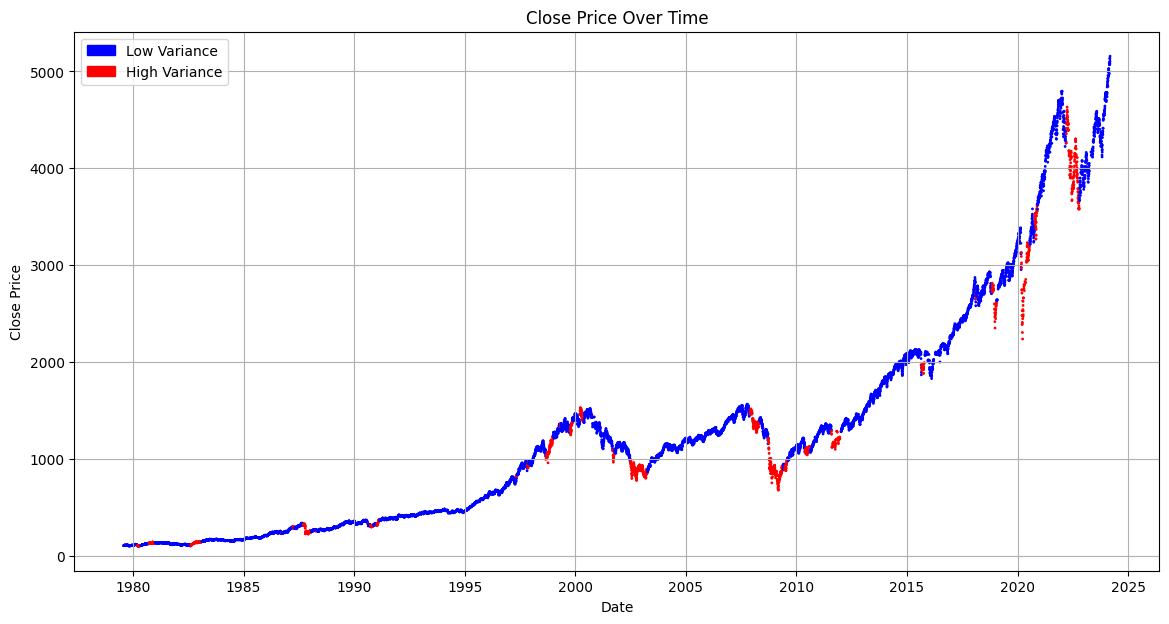

In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(14,7))
plt.scatter(sp1.index, sp3['Close'], c=sp3['color'], s=1)  # s=1 makes the dots smaller
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Create a custom legend
blue_patch = mpatches.Patch(color='blue', label='Low Variance')
red_patch = mpatches.Patch(color='red', label='High Variance')
plt.legend(handles=[blue_patch, red_patch])

plt.grid(True)
plt.show()

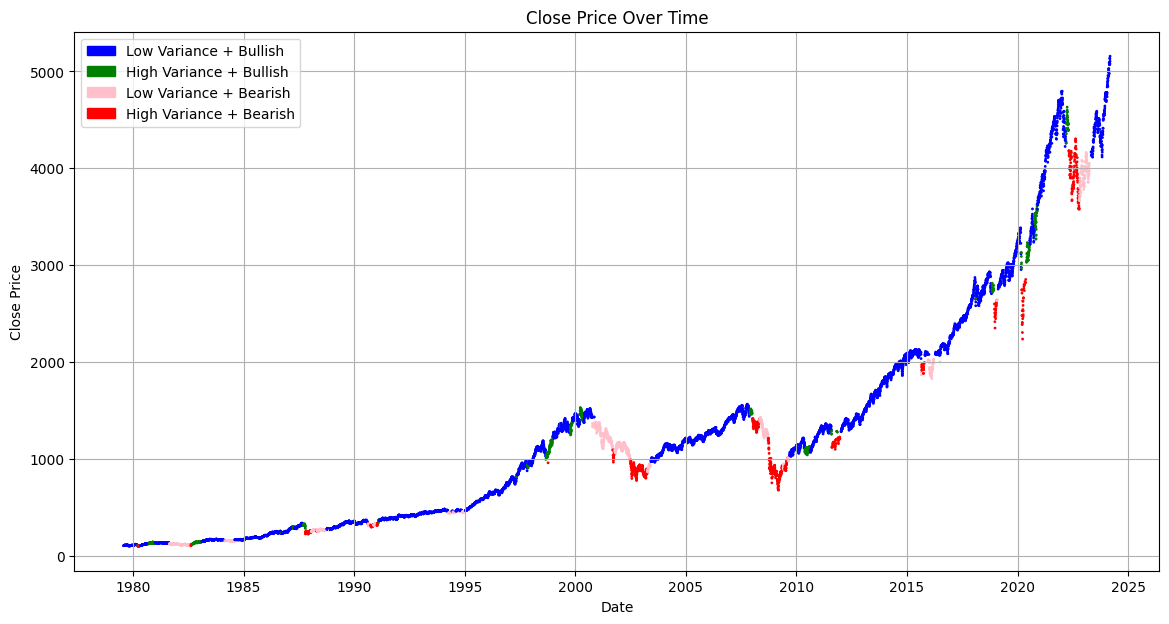

In [62]:
#plotting the different 4 regimes bull bear highvar, lowvar
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(14,7))
plt.scatter(sp1.index, sp1['Close'], c=sp1['color'], s=1)  # s=1 makes the dots smaller
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Create a custom legend
blue_patch = mpatches.Patch(color='blue', label='Low Variance + Bullish')
green_patch = mpatches.Patch(color='green', label='High Variance + Bullish')
pink_patch = mpatches.Patch(color='pink', label='Low Variance + Bearish')
red_patch = mpatches.Patch(color='red', label='High Variance + Bearish')
plt.legend(handles=[blue_patch, green_patch, pink_patch, red_patch])

plt.grid(True)
plt.show()

/Users/alden/quantfin/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


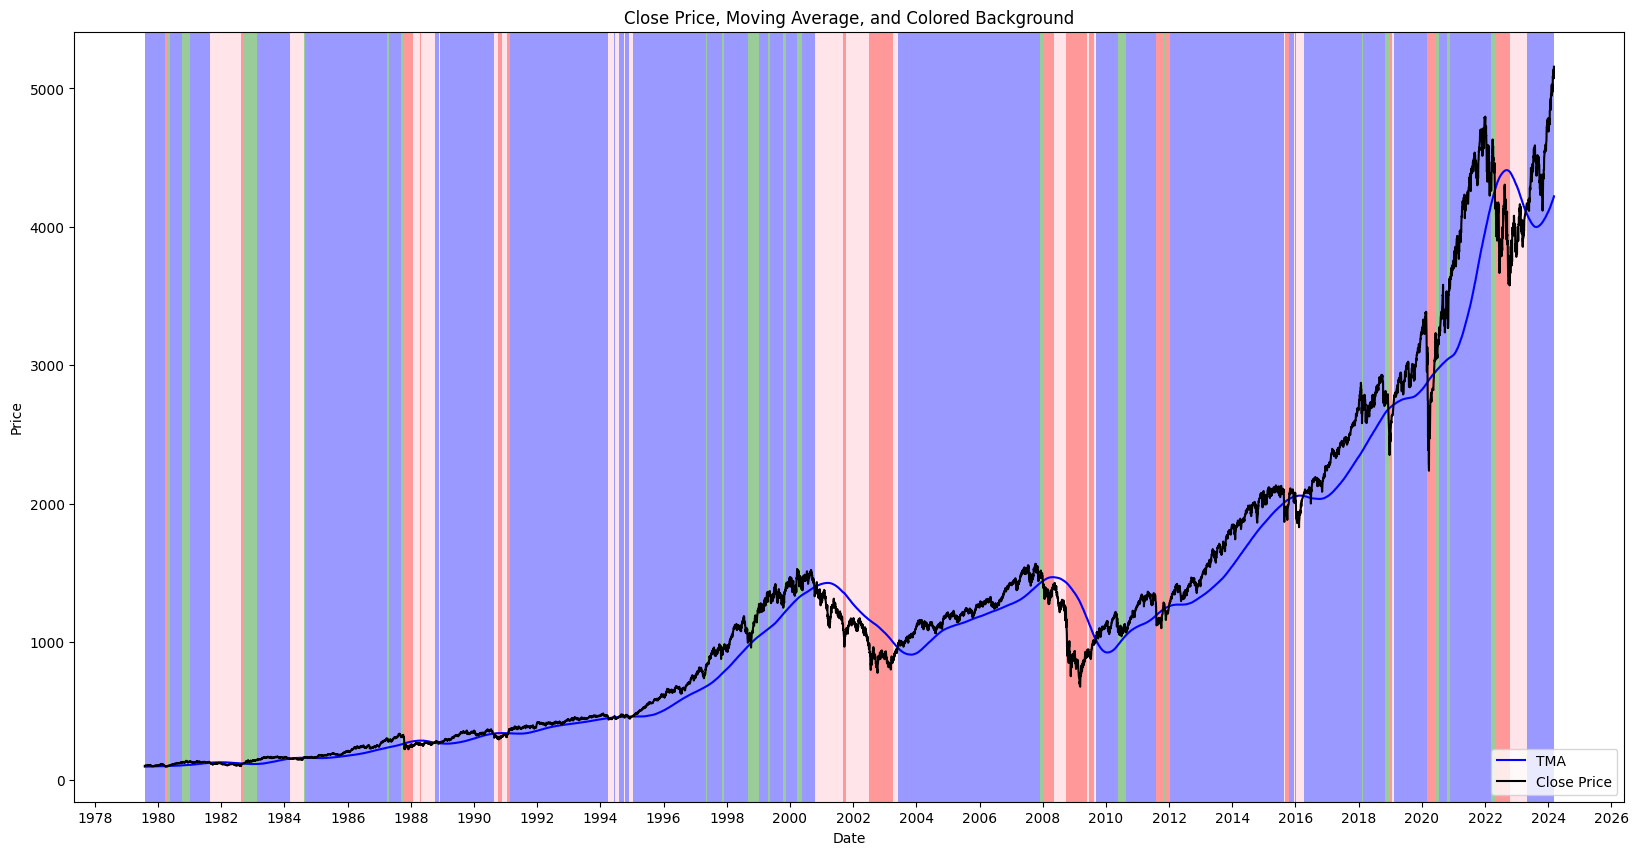

In [38]:
#green = bullish + high variance
#blue = bullish + low variance
#purple = bearish + low variance
#red = bearish + high variance
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd 
from matplotlib.patches import Patch


plt.figure(figsize=(20, 10))
plt.plot(sp1.index, sp1['TMA'], label='TMA', color='blue') 
plt.plot(sp1.index, sp1['Close'], label='Close Price', color='black') 

for i, row in sp1.iterrows():
    start_date = i
    end_date = sp1.index[sp1.index.get_loc(i) + 1] if i != sp1.index[-1] else i
    bg_color = row['color']

    plt.axvspan(start_date, end_date, facecolor=bg_color, alpha=0.4)

plt.title('Close Price, Moving Average, and Colored Background')
plt.xlabel('Date')
plt.ylabel('Price')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.show()

In [254]:
sp2 = sp1[8000:]
sp1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10706 entries, 1979-08-01 to 2024-03-07
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     10706 non-null  float64
 1   TMA       10706 non-null  float64
 2   ATR       10706 non-null  float64
 3   low_var   10706 non-null  float64
 4   high_var  10706 non-null  float64
 5   color     10706 non-null  object 
dtypes: float64(5), object(1)
memory usage: 843.5+ KB


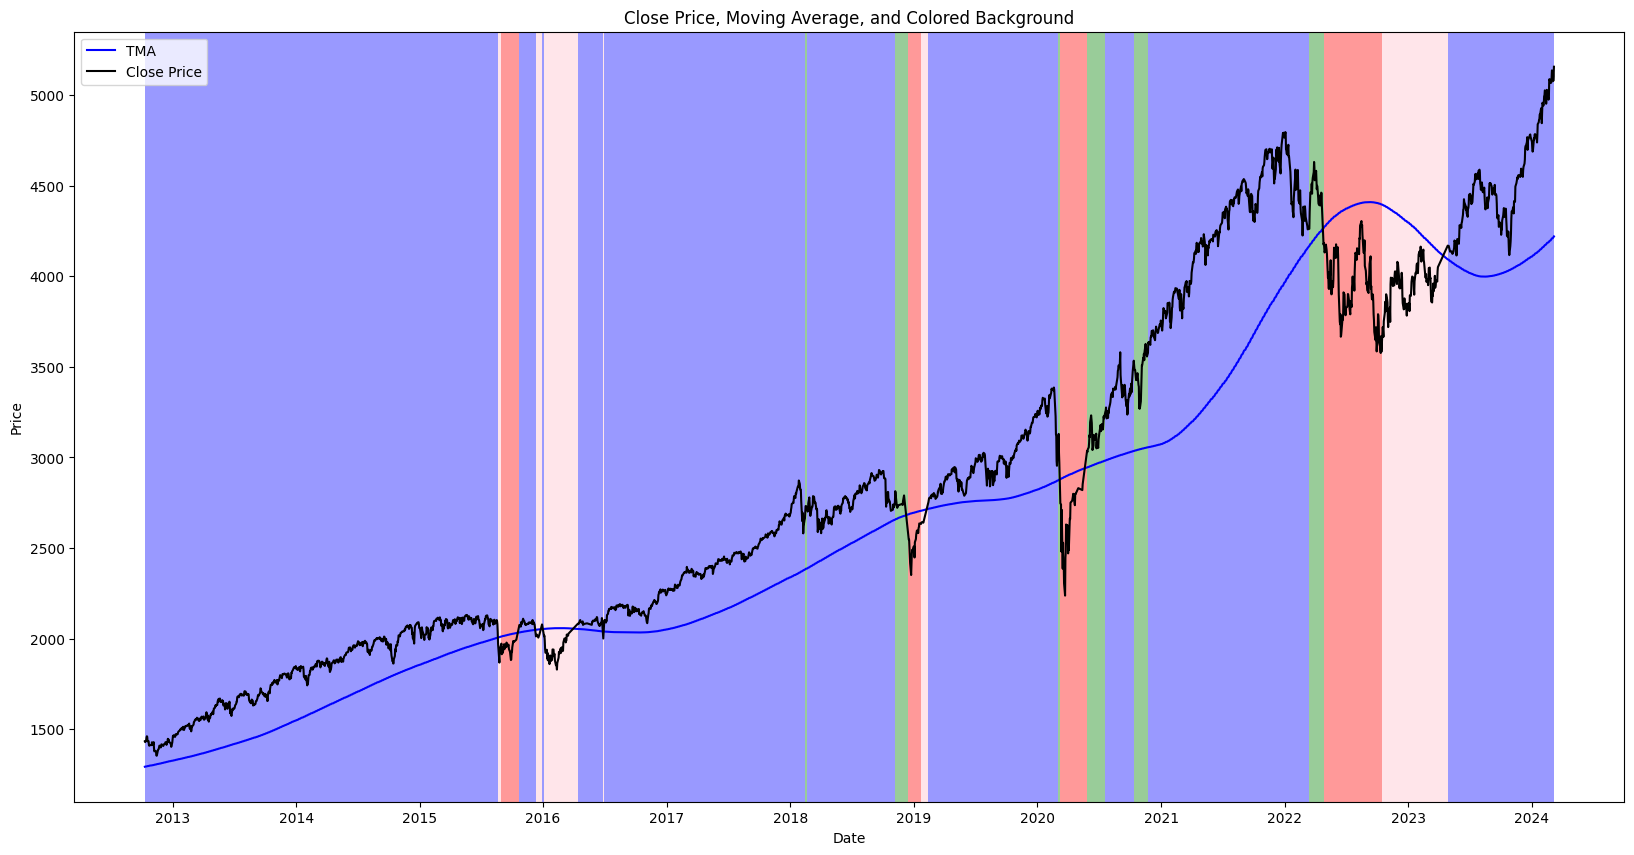

In [255]:
sp2.index = pd.to_datetime(sp2.index)
plt.figure(figsize=(20, 10))

plt.plot(sp2.index, sp2['TMA'], label='TMA', color='blue') 
plt.plot(sp2.index, sp2['Close'], label='Close Price', color='black') 

for i, row in sp2.iterrows():
    start_date2 = i
    end_date2 = sp2.index[sp2.index.get_loc(i) + 1] if i != sp2.index[-1] else i
    bg_color = row['color']

    plt.axvspan(start_date2, end_date2, facecolor=bg_color, alpha=0.4)

plt.title('Close Price, Moving Average, and Colored Background')
plt.xlabel('Date')
plt.ylabel('Price')


# Set the date format
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.show()

In [264]:
raw_daily = pd.read_csv('../data/s&p1978_2024.csv', skipfooter=1)
raw_daily.drop([' Open', ' High', ' Low', ' Close'],axis=1,inplace=True)
raw_daily.rename(columns={'Return': 'Return', ' Date':'Date'},inplace=True)

# Convert the 'date' column to datetime
raw_daily['Date'] = pd.to_datetime(raw_daily['Date'])
# Format the 'date' column in the desired format
raw_daily['Date'] = raw_daily['Date'].dt.strftime('%Y-%m-%d')
raw_daily['Date'] = pd.to_datetime(raw_daily['Date'])
# raw['Date'] = raw['Date'].dt.to_period('M').dt.to_timestamp()
# # raw['Date'] = raw['Date'].dt.strftime('%Y-%m-%d')
raw_daily.set_index('Date',inplace=True)
raw_daily = raw_daily.iloc[::-1]
# raw = raw.shift(1)
# raw = raw.resample('MS').sum()

#applying log transformation to the returns to compress the data
raw_daily = raw_daily.apply(lambda x: np.log(x))  


raw_daily.dropna(inplace=True)

raw_daily

/var/folders/7r/gmcfwl7x7f35wnm9l7114rtw0000gn/T/ipykernel_36401/1933038836.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  raw_daily = pd.read_csv('../data/s&p1978_2024.csv', skipfooter=1)
/var/folders/7r/gmcfwl7x7f35wnm9l7114rtw0000gn/T/ipykernel_36401/1933038836.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw_daily['Date'] = pd.to_datetime(raw_daily['Date'])


,Return
Date,
1978-01-04,-0.003203
1978-01-05,-0.008375
1978-01-06,-0.012150
1978-01-09,-0.010754
1978-01-10,-0.005199
...,...
2024-03-01,0.007976
2024-03-04,-0.001194
2024-03-05,-0.010245


In [265]:
sp.index = pd.to_datetime(sp.index)
sp1.index = pd.to_datetime(sp1.index)
merged_df = pd.merge(sp1, sp.drop('Close',axis=1), on='Date', how='inner')
merged_df.dropna(inplace=True)
merged_df['LN_return_excess'] = raw_daily
merged_df.dropna(inplace=True)
merged_df.drop(columns=['Return'],inplace=True)

In [266]:
merged_df.to_csv('../data/sp500_regimes.csv',index=True)

In [267]:
merged_df

,Close,TMA,ATR,low_var,high_var,color,Open,High,Low,LN_return_excess
Date,,,,,,,,,,
1979-08-01,104.17,98.711820,1.434875,0.996035,0.003965,blue,104.17,104.57,103.14,0.003462
1979-08-02,104.10,98.727573,1.434631,0.996035,0.003965,blue,104.10,105.02,103.59,-0.000672
1979-08-03,104.04,98.743241,1.422900,0.996035,0.003965,blue,104.04,104.56,103.36,-0.000577
1979-08-06,104.30,98.758868,1.421255,0.995664,0.004336,blue,104.30,104.66,103.27,0.002496
1979-08-07,105.65,98.774530,1.456692,0.995664,0.004336,blue,105.65,106.23,104.10,0.012860
...,...,...,...,...,...,...,...,...,...,...
2024-03-01,5137.08,4209.225794,42.351336,0.994032,0.005968,blue,5098.51,5140.33,5094.16,0.007976
2024-03-04,5130.95,4212.015419,41.358269,0.989347,0.010653,blue,5130.99,5149.67,5127.18,-0.001194
2024-03-05,5078.65,4214.827038,42.996855,0.989347,0.010653,blue,5110.52,5114.54,5056.82,-0.010245
